In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
df = pd.read_csv('../data_clean/merged_total.csv')
df.fillna('unknown', inplace=True)
df.shape

(250666, 19)

### Embedding

In [16]:
import nltk
import gensim
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\storm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\storm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:

embedding_model = "text-embedding-ada-002"

cat_cols = df_clean.select_dtypes(include=['object']).columns
cat_cols = cat_cols[(cat_cols != 'visit_bounce') & (cat_cols != 'contact_contactpersoon_id') & (cat_cols != 'account_account_id')]

cat_cols

Index(['afspraak_keyphrases', 'account_keyphrases', 'campagne_keyphrases',
       'sessie_keyphrases', 'visit_keyphrases', 'mailing_keyphrases'],
      dtype='object')

In [5]:
df[cat_cols].head()

,afspraak_keyphrases,account_keyphrases,campagne_keyphrases,sessie_keyphrases,visit_keyphrases,mailing_keyphrases
0,",","familiebedrijf, diensten, vastgoed, melle gent...","offline, netwerkevenement, ov kick off communi...","ma events, netwerking, netwerkactiviteit project",unknown,unknown
1,",","bedrijf, diensten, consultancy, geraardsbergen...","offline, opleiding, corona round tables sales","gr werking, marketing sales, opleidingen",unknown,unknown
2,"retentie lidmaatschap, ledenbezoek 2023, indus...","bedrijf, diensten, milieu, meilegem oudenaarde...","offline, netwerkevenement, nw nieuwjaarsrecept...","nw voka connect gent, netwerking, netwerkactiv...","chrome, windows, ghent, belgium, pro, event su...","jo stamgasten 2023, uitnodiging stamgasten 23 ..."
3,"retentie lidmaatschap, ledenbezoek 2023, indus...","bedrijf, diensten, milieu, meilegem oudenaarde...","offline, netwerkevenement, nw nieuwjaarsrecept...","nw voka connect gent, netwerking, netwerkactiv...","chrome, windows, ghent, belgium, telenet, acti...",nw nieuwjaarsreceptie vlaamse ardennen leiestr...
4,"retentie lidmaatschap, ledenbezoek 2023, indus...","bedrijf, diensten, milieu, meilegem oudenaarde...","offline, netwerkevenement, nw nieuwjaarsrecept...","nw voka connect gent, netwerking, netwerkactiv...","chrome, windows, ghent, belgium, pro, activite...","nieuwsbrief 09052023, nieuws van voka oost vla..."


In [6]:
len(df['afspraak_keyphrases'])

250666

In [7]:
from nltk.stem.snowball import SnowballStemmer
def remove_stopwords(text):
    stop_words_nl = set(stopwords.words('dutch'))
    
    word_tokens = word_tokenize(text, language='dutch')

    result = [x for x in word_tokens if x not in stop_words_nl]

    seperator = ', '
    return seperator.join(result)


def team_name_change(text):
    teams_dict = {
        'jo': ' jong ondernemen ',
        'do': ' duurzaam ondernemen ',
        'in': ' innovatie digitalisering ',
        'io': ' internationaal ondernemen ',
        'ao': ' arbeidsmarkt ',
        'ex': ' expert ',
        'gr': ' groei ',
        'bb': ' belangenbehartiging ',
        'co': ' communicatie ',
        'nw': ' netwerking ',
        'ha': ' haven ',
        'ma': ' match '
    }
    word_tokens = word_tokenize(text, language='dutch')
    # apply dict to list
    result = [teams_dict.get(word, word) for word in word_tokens]
    # join list to string
    cleaned_list = ', '.join(result)
    # tokenize string
    tokenize_list = word_tokenize(cleaned_list, language='dutch')
    # remove comma
    tokenize_list_no_comma = [x for x in tokenize_list if x != ',']
    # join list to string and remove duplicates from list
    return ', '.join(list(set(tokenize_list_no_comma)))


def stemmer(text):
    stemmer = SnowballStemmer(language='dutch')
    stem_sentence=[]
    for word in text.split(','):
        stem_sentence.append(stemmer.stem(word))
    stem_sentence= ', '.join(stem_sentence)
    return stem_sentence



def clean_text(df, cat_cols=cat_cols):

    df_copy = df.copy()

    for col in cat_cols:
        for row in range(len(df_copy)):
            name_change = team_name_change(df_copy[col][row])
            no_stopwords = remove_stopwords(name_change)
            tokenize_list = word_tokenize(no_stopwords, language='dutch')
            tokenize_list = [x for x in tokenize_list if x != ',']
            df_copy.at[row, col] = ', '.join(list(set(tokenize_list)))
            stemmer_list= stemmer(df_copy[col][row])
            df_copy.at[row, col] = stemmer_list
            
    return df_copy


def flatten_vector_columns(df, col):
    # Flatten the 'vector_column' into a matrix (with padding)
    max_vector_length = max(len(vector) for vector in df[col])
    padded_matrix = np.array([vector + [0.0] * (max_vector_length - len(vector)) for vector in df[col]])
    return padded_matrix

duurt 11.5 minuten om df_clean te maken (10cores) 51 min (4cores)

In [8]:
df_clean = clean_text(df=df, cat_cols=cat_cols)

In [9]:
del df

In [10]:
df_clean[cat_cols].head()

,afspraak_keyphrases,account_keyphrases,campagne_keyphrases,sessie_keyphrases,visit_keyphrases,mailing_keyphrases
0,,"mell, vastgoed, medewerker, gent, dienst, ...","kick, ov, vastgoed, offlin, bouw, off, n...","event, match, netwerk, netwerkactiviteit, ...",unknown,unknown
1,,"consultancy, aalst, bedrijf, dienst, conta...","sales, corona, offlin, tables, round, opleid","werking, sales, market, groei, opleid",unknown,unknown
2,"context, veronique, structur, mens, netwer...","ownermanager, milieu, bedrijf, meilegem, d...","nieuwjaarsreceptie, vlaander, offlin, oost,...","provinciaal, gent, netwerk, netwerkactivite...","belgium, ghent, session, chrom, mail, eve...","2023, jong, uitnod, mei, 23, stamgast, o..."
3,"context, veronique, structur, mens, netwer...","ownermanager, milieu, bedrijf, meilegem, d...","nieuwjaarsreceptie, vlaander, offlin, oost,...","provinciaal, gent, netwerk, netwerkactivite...","telenet, vlam, nieuwjaarsreceptie, ghent, ...","2023, vlam, leiestrek, nieuwjaarsreceptie, ..."
4,"context, veronique, structur, mens, netwer...","ownermanager, milieu, bedrijf, meilegem, d...","nieuwjaarsreceptie, vlaander, offlin, oost,...","provinciaal, gent, netwerk, netwerkactivite...","financiel, ghent, activiteit, chrom, mail,...","digitaliser, rechtstrek, nieuwsbrief, nieuw..."


In [19]:
for col in cat_cols:
    df_clean[col] = df_clean[col].str.replace(r'\d', '', regex=True).str.replace(', ,', ',').str.replace(r'(\s{2},\s{2}),*+', '', regex=True) \
        .str.replace('  ', ' ')
    df_clean[col] = df_clean[col].apply(lambda x: 'unknown' if len(x) == 0 else x)

In [20]:
df_clean[cat_cols].head()

,afspraak_keyphrases,account_keyphrases,campagne_keyphrases,sessie_keyphrases,visit_keyphrases,mailing_keyphrases
0,unknown,"mell, vastgoed, medewerker, gent, dienst, fami...","kick, ov, vastgoed, offlin, bouw, off, netwerk...","event, match, netwerk, netwerkactiviteit, project",unknown,unknown
1,unknown,"consultancy, aalst, bedrijf, dienst, contact, ...","sales, corona, offlin, tables, round, opleid","werking, sales, market, groei, opleid",unknown,unknown
2,"context, veronique, structur, mens, netwerk, l...","ownermanager, milieu, bedrijf, meilegem, diens...","nieuwjaarsreceptie, vlaander, offlin, oost, ne...","provinciaal, gent, netwerk, netwerkactiviteit,...","belgium, ghent, session, chrom, mail, event, s...",", jong, uitnod, mei, stamgast, ondernem"
3,"context, veronique, structur, mens, netwerk, l...","ownermanager, milieu, bedrijf, meilegem, diens...","nieuwjaarsreceptie, vlaander, offlin, oost, ne...","provinciaal, gent, netwerk, netwerkactiviteit,...","telenet, vlam, nieuwjaarsreceptie, ghent, acti...",", vlam, leiestrek, nieuwjaarsreceptie, vlaande..."
4,"context, veronique, structur, mens, netwerk, l...","ownermanager, milieu, bedrijf, meilegem, diens...","nieuwjaarsreceptie, vlaander, offlin, oost, ne...","provinciaal, gent, netwerk, netwerkactiviteit,...","financiel, ghent, activiteit, chrom, mail, man...","digitaliser, rechtstrek, nieuwsbrief, nieuw, v..."


In [21]:
if os.path.exists('../data_clean/rec_system.csv'):
    os.remove('../data_clean/rec_system.csv')
df_clean.to_csv('../data_clean/rec_system.csv', index=False)

In [12]:
df_clean['campagne_keyphrases'][2]

'nieuwjaarsreceptie,  vlaander,  offlin,  oost,  netwerk,  netwerkevenement,  regio'

### embedding

In [13]:
df_clean= pd.read_csv('../data_clean/rec_system.csv')
df_clean.head()

,financieledata_toegevoegde_waarde,financieledata_boekjaar_range,afspraak_keyphrases,afspraak_betreft,afspraak_account_gelinkt,account_keyphrases,inschrijving_aanwezig_afwezig,inschrijving_bron,inschrijving_facturatie_bedrag,campagne_keyphrases,sessie_keyphrases,visit_bounce,visit_duration,visit_first_visit,visit_total_pages,visit_keyphrases,visit_bouce,sentemail_kliks_clicks,mailing_keyphrases
0,413465.00,5.0,unknown,-1.0,-1.0,"mell, vastgoed, medewerker, gent, dienst, ...",1,1,50.0,"kick, ov, vastgoed, offlin, bouw, off, n...","event, match, netwerk, netwerkactiviteit, ...",unknown,-1.0,-1.0,-1.0,unknown,-1,-1.0,unknown
1,494107.00,9.0,unknown,-1.0,-1.0,"consultancy, aalst, bedrijf, dienst, conta...",1,1,0.0,"sales, corona, offlin, tables, round, opleid","werking, sales, market, groei, opleid",unknown,-1.0,-1.0,-1.0,unknown,-1,-1.0,unknown
2,1687010.57,3.0,"context, veronique, structur, mens, netwer...",2.0,1.0,"ownermanager, milieu, bedrijf, meilegem, d...",1,1,0.0,"nieuwjaarsreceptie, vlaander, offlin, oost,...","provinciaal, gent, netwerk, netwerkactivite...",Ja,0.0,0.0,1.0,"belgium, ghent, session, chrom, mail, eve...",1,52.0,", jong, uitnod, mei, stamgast, ondernem"
3,1687010.57,3.0,"context, veronique, structur, mens, netwer...",2.0,1.0,"ownermanager, milieu, bedrijf, meilegem, d...",1,1,0.0,"nieuwjaarsreceptie, vlaander, offlin, oost,...","provinciaal, gent, netwerk, netwerkactivite...",Ja,0.0,0.0,1.0,"telenet, vlam, nieuwjaarsreceptie, ghent, ...",1,18.0,", vlam, leiestrek, nieuwjaarsreceptie, vla..."
4,1687010.57,3.0,"context, veronique, structur, mens, netwer...",2.0,1.0,"ownermanager, milieu, bedrijf, meilegem, d...",1,1,0.0,"nieuwjaarsreceptie, vlaander, offlin, oost,...","provinciaal, gent, netwerk, netwerkactivite...",Ja,0.0,0.0,1.0,"financiel, ghent, activiteit, chrom, mail,...",1,136.0,"digitaliser, rechtstrek, nieuwsbrief, nieuw..."


In [22]:
df_clean.shape

(250666, 19)

In [34]:
import pandas as pd
import spacy

# Load the spaCy pre-trained Word2Vec model
nlp_en = spacy.load("en_core_web_md")
nlp_nl = spacy.load("nl_core_news_sm")

# Create a sample DataFrame
sentence = df_clean['campagne_keyphrases'][2]

# Define a function to get the Word2Vec vector for a keyphrase
def embed_sentence(sentence):
    # data= []
    # for word in sentence.split(','):
    #     doc = nlp_nl(word)
    #     data.append(word)
    # print(len(data))
    doc = nlp_nl(sentence)
    return np.mean(doc.vector)

def embedding_model(df_clean, cat_cols=cat_cols):
    df_copy = df_clean.copy()
    for col in cat_cols:
        for row in range(len(df_copy)):
            df_copy.at[row, col] = embed_sentence(df_copy[col][row])
    return df_copy


duurt 157 min (4cores) #rip

In [37]:
df_embed = embedding_model(df_clean=df_clean, cat_cols=cat_cols)

In [38]:
df_embed.head()

,financieledata_toegevoegde_waarde,financieledata_boekjaar_range,afspraak_keyphrases,afspraak_betreft,afspraak_account_gelinkt,account_keyphrases,inschrijving_aanwezig_afwezig,inschrijving_bron,inschrijving_facturatie_bedrag,campagne_keyphrases,sessie_keyphrases,visit_bounce,visit_duration,visit_first_visit,visit_total_pages,visit_keyphrases,visit_bouce,sentemail_kliks_clicks,mailing_keyphrases
0,413465.00,5.0,0.013675,-1.0,-1.0,-0.009223,1,1,50.0,-0.008486,-0.006258,unknown,-1.0,-1.0,-1.0,0.013675,-1,-1.0,0.013675
1,494107.00,9.0,0.013675,-1.0,-1.0,-0.003056,1,1,0.0,-0.004275,-0.010647,unknown,-1.0,-1.0,-1.0,0.013675,-1,-1.0,0.013675
2,1687010.57,3.0,-0.007187,2.0,1.0,-0.000462,1,1,0.0,-0.003388,-0.004251,Ja,0.0,0.0,1.0,-0.010881,1,52.0,0.002856
3,1687010.57,3.0,-0.007187,2.0,1.0,-0.000462,1,1,0.0,-0.003388,-0.004251,Ja,0.0,0.0,1.0,-0.011375,1,18.0,-0.004773
4,1687010.57,3.0,-0.007187,2.0,1.0,-0.000462,1,1,0.0,-0.003388,-0.004251,Ja,0.0,0.0,1.0,-0.016026,1,136.0,-0.006436


In [39]:
if os.path.exists('../data_clean/rec_system_embedded.csv'):
    os.remove('../data_clean/rec_system_embedded.csv')
df_embed.to_csv('../data_clean/rec_system_embedded.csv', index=False)

### preprocessing

In [58]:
df_embed = pd.read_csv('../data_clean/rec_system_embedded.csv')

In [59]:
#change dtype to float
df_embed["account_keyphrases"] = df_embed["account_keyphrases"].astype(float)
df_embed["sessie_keyphrases"] = df_embed["sessie_keyphrases"].astype(float)
df_embed["visit_keyphrases"] = df_embed["visit_keyphrases"].astype(float)
df_embed["mailing_keyphrases"] = df_embed["mailing_keyphrases"].astype(float)
df_embed["campagne_keyphrases"] = df_embed["campagne_keyphrases"].astype(float)

In [60]:
df_embed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250666 entries, 0 to 250665
Data columns (total 19 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   financieledata_toegevoegde_waarde  250666 non-null  float64
 1   financieledata_boekjaar_range      250666 non-null  float64
 2   afspraak_keyphrases                250666 non-null  float64
 3   afspraak_betreft                   250666 non-null  float64
 4   afspraak_account_gelinkt           250666 non-null  float64
 5   account_keyphrases                 250666 non-null  float64
 6   inschrijving_aanwezig_afwezig      250666 non-null  int64  
 7   inschrijving_bron                  250666 non-null  int64  
 8   inschrijving_facturatie_bedrag     250666 non-null  float64
 9   campagne_keyphrases                250666 non-null  float64
 10  sessie_keyphrases                  250666 non-null  float64
 11  visit_bounce                       2506

In [61]:
category_cols = df_embed.select_dtypes(include=['object']).columns
print("categorical cols: ",category_cols)
numeric_cols = df_embed.select_dtypes(include=['float64']).columns
print("numerical cols : ", numeric_cols)

categorical cols:  Index(['visit_bounce'], dtype='object')
numerical cols :  Index(['financieledata_toegevoegde_waarde', 'financieledata_boekjaar_range',
       'afspraak_keyphrases', 'afspraak_betreft', 'afspraak_account_gelinkt',
       'account_keyphrases', 'inschrijving_facturatie_bedrag',
       'campagne_keyphrases', 'sessie_keyphrases', 'visit_duration',
       'visit_first_visit', 'visit_total_pages', 'visit_keyphrases',
       'sentemail_kliks_clicks', 'mailing_keyphrases'],
      dtype='object')


In [62]:
df_embed.head()

,financieledata_toegevoegde_waarde,financieledata_boekjaar_range,afspraak_keyphrases,afspraak_betreft,afspraak_account_gelinkt,account_keyphrases,inschrijving_aanwezig_afwezig,inschrijving_bron,inschrijving_facturatie_bedrag,campagne_keyphrases,sessie_keyphrases,visit_bounce,visit_duration,visit_first_visit,visit_total_pages,visit_keyphrases,visit_bouce,sentemail_kliks_clicks,mailing_keyphrases
0,413465.00,5.0,0.013675,-1.0,-1.0,-0.009223,1,1,50.0,-0.008486,-0.006258,unknown,-1.0,-1.0,-1.0,0.013675,-1,-1.0,0.013675
1,494107.00,9.0,0.013675,-1.0,-1.0,-0.003056,1,1,0.0,-0.004275,-0.010647,unknown,-1.0,-1.0,-1.0,0.013675,-1,-1.0,0.013675
2,1687010.57,3.0,-0.007187,2.0,1.0,-0.000462,1,1,0.0,-0.003388,-0.004251,Ja,0.0,0.0,1.0,-0.010881,1,52.0,0.002856
3,1687010.57,3.0,-0.007187,2.0,1.0,-0.000462,1,1,0.0,-0.003388,-0.004251,Ja,0.0,0.0,1.0,-0.011375,1,18.0,-0.004773
4,1687010.57,3.0,-0.007187,2.0,1.0,-0.000462,1,1,0.0,-0.003388,-0.004251,Ja,0.0,0.0,1.0,-0.016026,1,136.0,-0.006436


In [63]:
df_embed["visit_bouce"].value_counts()

visit_bouce
 1    118026
 0    105823
-1     26817
Name: count, dtype: int64

In [64]:
df_embed.drop(columns=['visit_bounce'], inplace=True)

In [65]:
df_embed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250666 entries, 0 to 250665
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   financieledata_toegevoegde_waarde  250666 non-null  float64
 1   financieledata_boekjaar_range      250666 non-null  float64
 2   afspraak_keyphrases                250666 non-null  float64
 3   afspraak_betreft                   250666 non-null  float64
 4   afspraak_account_gelinkt           250666 non-null  float64
 5   account_keyphrases                 250666 non-null  float64
 6   inschrijving_aanwezig_afwezig      250666 non-null  int64  
 7   inschrijving_bron                  250666 non-null  int64  
 8   inschrijving_facturatie_bedrag     250666 non-null  float64
 9   campagne_keyphrases                250666 non-null  float64
 10  sessie_keyphrases                  250666 non-null  float64
 11  visit_duration                     2506

In [ ]:
# df_merged = pd.read_csv('../data_clean/merged_total.csv')
# df_embed['campagne_type_campagne']= df_merged['campagne_type_campagne']

# #encode categorical columns
# from sklearn.preprocessing import LabelEncoder

# label_encoder = LabelEncoder()
# df_embed['campagne_type_campagne'] = label_encoder.fit_transform(df_embed['campagne_type_campagne'])

# df_embed.head()

### CLUSTERING

In [67]:
from sklearn.cluster import DBSCAN

In [68]:
dbscan = DBSCAN(eps=0.5, min_samples=5, )
dbscan.fit(df_embed)

DBSCAN()

In [69]:
import pandas as pd

DBSCAN_dataset = pd.DataFrame(df_embed)
DBSCAN_dataset.loc[:,'Cluster'] = dbscan.labels_ 

labels_db = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels_db)) - (1 if -1 in labels_db else 0)
n_noise_ = list(labels_db).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 11283
Estimated number of noise points: 113219


In [70]:
dbscan.get_params(deep=True)

{'algorithm': 'auto',
 'eps': 0.5,
 'leaf_size': 30,
 'metric': 'euclidean',
 'metric_params': None,
 'min_samples': 5,
 'n_jobs': None,
 'p': None}

In [71]:
DBSCAN_dataset.Cluster.value_counts().to_frame()

,count
Cluster,
-1,113219
55,1261
95,1180
9044,564
8565,539
...,...
2932,1
2931,1
2930,1


In [72]:
DBSCAN_dataset.head()

,financieledata_toegevoegde_waarde,financieledata_boekjaar_range,afspraak_keyphrases,afspraak_betreft,afspraak_account_gelinkt,account_keyphrases,inschrijving_aanwezig_afwezig,inschrijving_bron,inschrijving_facturatie_bedrag,campagne_keyphrases,sessie_keyphrases,visit_duration,visit_first_visit,visit_total_pages,visit_keyphrases,visit_bouce,sentemail_kliks_clicks,mailing_keyphrases,campagne_type_campagne,Cluster
0,413465.00,5.0,0.013675,-1.0,-1.0,-0.009223,1,1,50.0,-0.008486,-0.006258,-1.0,-1.0,-1.0,0.013675,-1,-1.0,0.013675,2,-1
1,494107.00,9.0,0.013675,-1.0,-1.0,-0.003056,1,1,0.0,-0.004275,-0.010647,-1.0,-1.0,-1.0,0.013675,-1,-1.0,0.013675,3,-1
2,1687010.57,3.0,-0.007187,2.0,1.0,-0.000462,1,1,0.0,-0.003388,-0.004251,0.0,0.0,1.0,-0.010881,1,52.0,0.002856,2,-1
3,1687010.57,3.0,-0.007187,2.0,1.0,-0.000462,1,1,0.0,-0.003388,-0.004251,0.0,0.0,1.0,-0.011375,1,18.0,-0.004773,2,-1
4,1687010.57,3.0,-0.007187,2.0,1.0,-0.000462,1,1,0.0,-0.003388,-0.004251,0.0,0.0,1.0,-0.016026,1,136.0,-0.006436,2,0


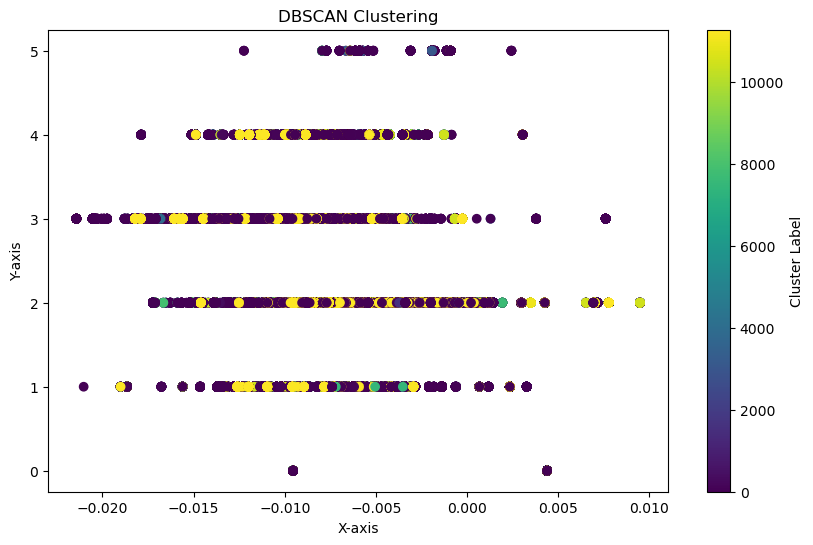

In [73]:
cluster_labels = DBSCAN_dataset['Cluster']

#standard scale deze kolommen en je bekomt de juiste clusters?
x_col = 'campagne_keyphrases'
y_col = 'campagne_type_campagne'

X = DBSCAN_dataset[x_col]
Y = DBSCAN_dataset[y_col]
cluster_labels = DBSCAN_dataset['Cluster']
# Create a scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(X, Y, c=cluster_labels , cmap='viridis')
plt.title('DBSCAN Clustering')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.colorbar(label='Cluster Label')
plt.show()